In [1]:
from qiime2.plugins import fondue
from qiime2 import Artifact

import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import time

%matplotlib inline

In [2]:
ids = Artifact.import_data('NCBIAccessionIDs', 'ids.tsv')
email = 'your@email.com'
n = 3

## Fetch data

### Four jobs
Fetch 20 runs using 4 parallel jobs.

In [3]:
times_many = []
n_jobs = 4

for i in range(n):
    t0 = time.time()
    results = fondue.methods.get_sequences(
        accession_ids=ids, 
        email=email,
        n_jobs=n_jobs,
        log_level='ERROR'
    )
    del results
    
    t1 = time.time()
    times_many.append(t1 - t0)
    print(times_many)
    time.sleep(600)

### One job
Fetch 20 runs using a single job.

In [4]:
times_one = []
n_jobs = 1

for i in range(n):
    t0 = time.time()
    results = fondue.methods.get_sequences(
        accession_ids=ids, 
        email=email,
        n_jobs=n_jobs,
        log_level='ERROR'
    )
    del results
    
    t1 = time.time()
    times_one.append(t1 - t0)
    time.sleep(600)

## Evaluate results

Read in total run times (in minutes).

In [5]:
if not os.path.isfile('benchmark_result.csv'):
    results_df = pd.DataFrame(
        {'total_time': [x/60 for x in times_many + times_one],
         'n_jobs': [4, 4, 4, 1, 1, 1]}
    )
    results_df.to_csv('benchmark_result.csv', index=False)
else:
    results_df = pd.read_csv('benchmark_result.csv')

In [6]:
results_df

,total_time,n_jobs
0,49.397727,4
1,57.076594,4
2,55.192875,4
3,178.455487,1
4,139.965826,1
5,156.752344,1


Calculate summary stats.

In [7]:
results_df.groupby('n_jobs').describe()

total_time                                                             \
            count        mean        std         min         25%         50%   
n_jobs                                                                         
1             3.0  158.391219  19.297097  139.965826  148.359085  156.752344   
4             3.0   53.889065   4.002023   49.397727   52.295301   55.192875   

                                
               75%         max  
n_jobs                          
1       167.603915  178.455487  
4        56.134735   57.076594

Read in download and processing times (in minutes).

In [8]:
download_times = pd.read_csv('benchmark_download_times.csv')

In [9]:
download_times

,download_time,processing_time,n_jobs
0,19.50,25.0,4
1,8.50,49.5,4
2,8.00,43.0,4
3,8.25,170.0,1
4,8.50,132.0,1
5,8.50,137.0,1


Calculate summary stats.

In [10]:
download_times.groupby('n_jobs').describe()

download_time                                                     \
               count       mean       std   min    25%  50%   75%   max   
n_jobs                                                                    
1                3.0   8.416667  0.144338  8.25  8.375  8.5   8.5   8.5   
4                3.0  12.000000  6.500000  8.00  8.250  8.5  14.0  19.5   

       processing_time                                                      \
                 count        mean        std    min    25%    50%     75%   
n_jobs                                                                       
1                  3.0  146.333333  20.647841  132.0  134.5  137.0  153.50   
4                  3.0   39.166667  12.691861   25.0   34.0   43.0   46.25   

               
          max  
n_jobs         
1       170.0  
4        49.5

Merge both DataFrames into a single object and remove unnecessary columns.

In [11]:
results_all = results_df.merge(download_times, left_index=True, right_index=True)
results_all.drop('n_jobs_y', inplace=True, axis=1)

In [12]:
results_all

,total_time,n_jobs_x,download_time,processing_time
0,49.397727,4,19.50,25.0
1,57.076594,4,8.50,49.5
2,55.192875,4,8.00,43.0
3,178.455487,1,8.25,170.0
4,139.965826,1,8.50,132.0
5,156.752344,1,8.50,137.0


Calculate summary stats.

In [13]:
times_mean = results_all.groupby('n_jobs_x').mean().reset_index()
times_mean

,n_jobs_x,total_time,download_time,processing_time
0,1,158.391219,8.416667,146.333333
1,4,53.889065,12.000000,39.166667


In [14]:
times_std = results_all.groupby('n_jobs_x').std().reset_index()
times_std

,n_jobs_x,total_time,download_time,processing_time
0,1,19.297097,0.144338,20.647841
1,4,4.002023,6.500000,12.691861


Melt the DataFrame to change its format for plotting with seaborn.

In [15]:
results_all_melt = pd.melt(results_all, id_vars='n_jobs_x', value_vars=['download_time', 'processing_time', 'total_time'])
results_all_melt

,n_jobs_x,variable,value
0,4,download_time,19.500000
1,4,download_time,8.500000
2,4,download_time,8.000000
3,1,download_time,8.250000
4,1,download_time,8.500000
5,1,download_time,8.500000
6,4,processing_time,25.000000
7,4,processing_time,49.500000
8,4,processing_time,43.000000
9,1,processing_time,170.000000


Generate a bar plot for all the analyzed times.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


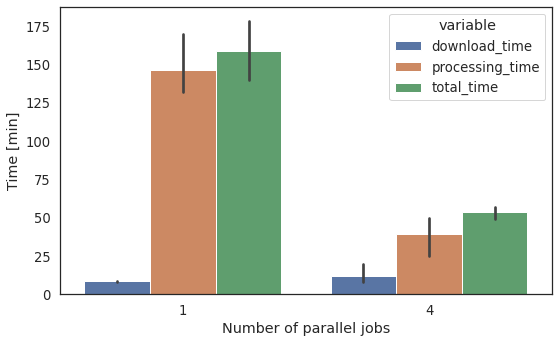

In [16]:
sns.set(rc={'figure.figsize':(8, 5), 'font.family': ['Arial']}, style='white')
with sns.plotting_context("notebook", font_scale=1.2):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    sns.barplot(
        x="n_jobs_x", 
        y="value", 
        hue='variable', 
        data=results_all_melt,
        ax=ax,
    )
    
    ax.set_xlabel(f'Number of parallel jobs')
    ax.set_ylabel(f'Time [min]')
    
    plt.tight_layout()

In [17]:
fig.savefig('parallelization_test.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
